calc_fund_freq= 49.7203
calc_left_freq= 39.77624
calc_right_freq= 59.66436
new_nb_samples_range=  32865
Fundamental ampl 340.0
3rd harmonic ampl 34.0
5rd harmonic ampl 22.66
left SB ampl 0.1
right SB ampl 0.103
Fundamental angle -90.2  degrees
third harmonic angl -90.6  degrees
fith harmonic angl 89.0  degrees
left sd angle 5.9  degrees
right sd angle -173.2  degrees


"\nx=np.linspace(0,total_time,sample_rate) # x axis samples\nplot(x, src_v,  label='Grid volts')\nplt.legend()\nplt.grid()\ngcf().set_size_inches(10,3)\nshow()\n"

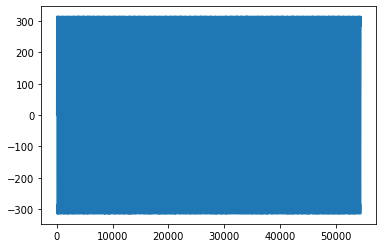

In [2]:
import numpy as np
from scipy import signal
import scipy
import cmath
import matplotlib.pyplot as plt


pi=np.pi
sq2=2**0.5
fund_freq = 49.72# Hz  
fund_ampl=340
modulating_freq=(1/5)*fund_freq #Hz
modulating_ampl=0.2 #side bands amplitude will be half
sample_rate=9078
total_time=6
total_nb_samples=sample_rate*total_time
src_v=[0]*total_nb_samples 
x = np.linspace(0, total_time, sample_rate)

# create canonical  signal
for n in range(0,total_nb_samples): 
    time=n/sample_rate
    src_v[n]= (fund_ampl+ modulating_ampl*np.sin(2*pi*modulating_freq*time))*np.sin(2*pi*fund_freq*time)\
    + fund_ampl/10*np.sin(2*pi*fund_freq*3*time) -fund_ampl/15*np.sin(2*pi*fund_freq*5*time) # add some harmonics 3rd and 5th
src_v=src_v+ np.random.normal(0,0.2,total_nb_samples) #a bit of noise

plt.plot(src_v)

#low pass filter at 90 Hz   A low pass is needed to reduce aliaising to find fundamental magnitude acurately
a,b=signal.butter(4,90,'low',False,'ba',sample_rate)
src_v_lp= signal.filtfilt(a,b,src_v) # signal after low pass
#a window...helps getting fundamental acurately
tuckey_window=signal.tukey(total_nb_samples,0.5,True)
src_v_w=src_v_lp*tuckey_window
src_v_w -= np.mean(src_v_w)
fft = np.fft.rfft(src_v_w, norm="ortho")
def abs2(x):
    return x.real**2 + x.imag**2
fftmag=abs2(fft)[:sample_rate]
# find predominent peak ampl freq 1 give single result
#for prospective frequency
peaks, _= signal.find_peaks(fftmag, height=np.max(fftmag)*1.0) 

#compute the mean frequency of the peak with respect to power density
powerpeak=np.zeros(len(peaks))
powerpeaktimefrequency=np.zeros(len(peaks))
# look for peak amplitude freq in all nyquist prospective freq has n/2 frequencies
for i in range(int(sample_rate/2)-1):
    dist=sample_rate
    jnear=0
    for j in range(len(peaks)):
        if dist>np.abs(i-peaks[j]):
             dist=np.abs(i-peaks[j])
             jnear=j
    powerpeak[jnear]+=fftmag[i]
    powerpeaktimefrequency[jnear]+=fftmag[i]*i
powerpeaktimefrequency=np.divide(powerpeaktimefrequency,powerpeak)/total_time
#print ('Fundamental frequency= ', powerpeaktimefrequency)

calc_fund_freq=powerpeaktimefrequency[0]  #Get fundamental only
calc_left_freq=(4/5)*calc_fund_freq 
calc_right_freq=(6/5)*calc_fund_freq # the side bands are at precisely fraction of fundamental
print('calc_fund_freq=' ,round(calc_fund_freq ,6))
print('calc_left_freq=' ,round(calc_left_freq ,6))
print('calc_right_freq=',round(calc_right_freq,6))

#2) Find grid fundamental, harmonics  and side band frequencies amplitude and angles
#-----------------------------------------------------------------------------------
#take sub-secction of sample range to prevent overflow for freq < 50,
# add 0.5 to get beter rounding. Taking multiple of 15 cycles 
new_nb_samples_range=int(0.5+0.6*total_nb_samples*50/calc_fund_freq)  

print('new_nb_samples_range= ',new_nb_samples_range)

ye1=[0+0j]*new_nb_samples_range
ye3=[0+0j]*new_nb_samples_range
ye5=[0+0j]*new_nb_samples_range
ye4_5=[0+0j]*new_nb_samples_range
ye6_5=[0+0j]*new_nb_samples_range

for g in range(0,new_nb_samples_range):  
    # Synchronous detection approach now knowing the frequencies accurately
    #no filtering or window on signal gives best results
  time=g/sample_rate
    # original signal 
  ye1[g]  =src_v[g]*cmath.exp(0-1j*2*pi*calc_fund_freq*time)       # fundamental
  ye3[g]  =src_v[g]*cmath.exp(0-1j*2*pi*calc_fund_freq*3*time)     # third harm
  ye5[g]  =src_v[g]*cmath.exp(0-1j*2*pi*calc_fund_freq*5*time)     # 5th harm
  ye4_5[g]=src_v[g]*cmath.exp(0-1j*2*pi*calc_fund_freq*(4/5)*time) # left side band at 4/5 of fund freq
  ye6_5[g]=src_v[g]*cmath.exp(0-1j*2*pi*calc_fund_freq*(6/5)*time) # right side band at 6/5 of fund freq
sum1=sum(ye1)*2/(new_nb_samples_range)     # integrate over range and dvide by nb ofsamples in range
sum3=sum(ye3)*2/(new_nb_samples_range)
sum5=sum(ye5)*2/(new_nb_samples_range)
sum4_5=sum(ye4_5)*2/(new_nb_samples_range)
sum6_5=sum(ye6_5)*2/(new_nb_samples_range)
a1=abs(sum1)
a3=abs(sum3)
a5=abs(sum5)
a4_5=abs(sum4_5)
a6_5=abs(sum6_5)
theta1  =np.angle(sum1)/pi*180
theta3  =np.angle(sum3)/pi*180
theta5  =np.angle(sum5)/pi*180
theta4_5=np.angle(sum4_5)/pi*180
theta6_5=np.angle(sum6_5)/pi*180

print('Fundamental ampl'  ,round(a1,2))
print('3rd harmonic ampl' ,round(a3,2))
print('5rd harmonic ampl' ,round(a5,2))
print('left SB ampl'      ,round(a4_5,3))
print('right SB ampl'     ,round(a6_5,3))

print('Fundamental angle'  ,round(theta1,1),  ' degrees')
print('third harmonic angl',round(theta3,1),  ' degrees')
print('fith harmonic angl' ,round(theta5,1),  ' degrees')
print('left sd angle'      ,round(theta4_5,1),' degrees')
print('right sd angle'     ,round(theta6_5,1),' degrees')
"""
x=np.linspace(0,total_time,sample_rate) # x axis samples
plot(x, src_v,  label='Grid volts')
plt.legend()
plt.grid()
gcf().set_size_inches(10,3)
show()
"""
